In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import src.wrangle as wr

from importlib import reload


pd.options.display.float_format = '{:,.3f}'.format

In [2]:
# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [30]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/clustering-project/src/wrangle.py'>

In [31]:
train, _, _ = wr.split_zillow(wr.get_zillow())

In [33]:
train.iloc[:, :11].columns.tolist()

['sqft',
 'garage_sqft',
 'lot_sqft',
 'age',
 'structure_price',
 'price',
 'land_price',
 'tax_amount',
 'bath',
 'beds',
 'bed_bath_ratio']

In [37]:
columns_to_scale = train.iloc[:, :11].columns.tolist()
sc = StandardScaler()
#train_scaled = pd.DataFrame(sc.fit_transform(train[columns_to_scale]), columns=columns_to_scale)
train_scaled = standard_scale_one_df(train)

In [45]:
train_clust = train_scaled.iloc[:, :-2]

In [35]:
def standard_scale_zillow(train, validate, test):
    '''
    accepts train, validate, test data sets
    scales the data in each of them
    returns transformed data sets
    '''

    col = train.iloc[:, :11].columns.tolist()
    
    # create scalers
    scaler = StandardScaler()    
    #qt = QuantileTransformer(output_distribution='normal')
    scaler.fit(train[col])
    train[col] = scaler.transform(train[col])
    validate[col] = scaler.transform(validate[col])
    test[col] = scaler.transform(test[col])
    
    return train, validate, test

In [36]:
def standard_scale_one_df(train):
    col = train.iloc[:, :11].columns.tolist()
    
    # create scalers
    scaler = StandardScaler()    
    #qt = QuantileTransformer(output_distribution='normal')
    scaler.fit(train[col])
    train[col] = scaler.transform(train[col])
    return train

In [17]:
train_scaled.head()

,sqft,garage_sqft,lot_sqft,age,structure_price,price,land_price,tax_amount,bed_bath_ratio
0,1.490,-0.684,-0.006,-0.794,0.927,0.206,-0.148,0.122,0.025
1,-0.851,-0.684,-0.053,1.729,-0.261,0.217,0.409,0.121,0.593
2,-0.243,-0.684,-0.048,0.622,-0.203,-0.224,-0.206,-0.243,0.593
3,-0.687,-0.684,-0.060,0.534,-0.794,-0.735,-0.618,-0.676,-0.267
4,0.263,-0.684,-0.050,-0.529,0.178,0.211,0.201,0.324,-0.560


#### Exploration

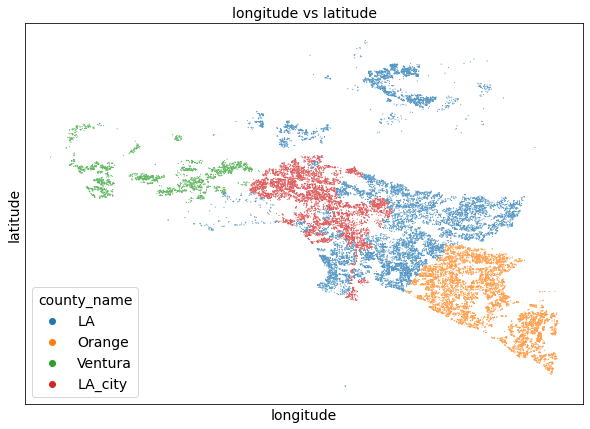

In [93]:
visualize_map(train)

In [92]:
def visualize_map(df):
    '''
    this function accepts a data frame as a parameter
    and print out a map of counties based on their latitude and longitude
    '''
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=train, x='longitude', y='latitude', s=1, hue='county_name')
    plt.title('longitude vs latitude')
    plt.yticks([])
    plt.xticks([])

([], [])

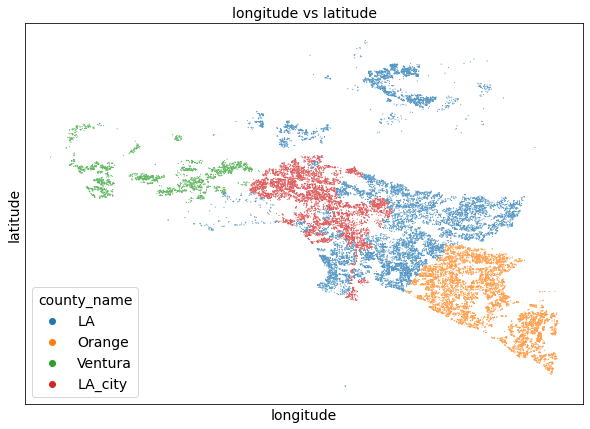

In [91]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=train, x='longitude', y='latitude', s=1, hue='county_name')
plt.title('longitude vs latitude')
plt.yticks([])
plt.xticks([])

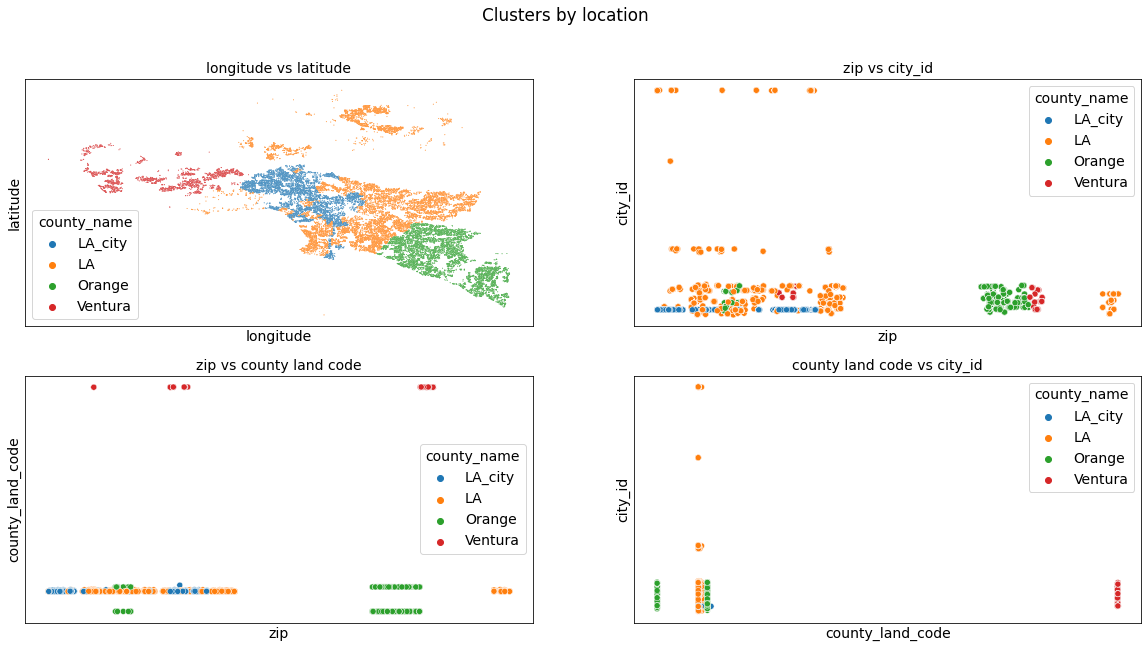

In [154]:
plt.figure(figsize=(20, 10))
plt.suptitle('Clusters by location')

plt.subplot(221)
sns.scatterplot(data=train, x='longitude', y='latitude', s=1, hue='county_name')
plt.title('longitude vs latitude')
plt.yticks([])
plt.xticks([])
          
plt.subplot(222)
sns.scatterplot(data=train, x='zip', y='city_id', hue='county_name')
plt.title('zip vs city_id')
plt.yticks([])
plt.xticks([])
    
plt.subplot(223)
sns.scatterplot(data=train, x='zip', y='county_land_code', hue='county_name')
plt.title('zip vs county land code')
plt.yticks([])
plt.xticks([])

plt.subplot(224)
sns.scatterplot(data=train, x='county_land_code', y='city_id', hue='county_name')
plt.title('county land code vs city_id')
plt.yticks([])
plt.xticks([])

plt.show()

In [110]:
train['tax_per_price'] = train.price / train.tax_amount

In [111]:
train.tax_per_price

29866   83.533
11090   78.805
35353   93.931
45550   99.261
25637   81.310
         ...  
43828   73.530
49842   74.181
39253   89.373
27389   81.536
13389   80.094
Name: tax_per_price, Length: 27764, dtype: float64

In [44]:
clustering = train[['city_id', 'zip','latitude', 'longitude', 'county_land_code', 'county_name']]

In [45]:
clustering['county_number'] = clustering.county_name.map({'LA':0, 'Ventura':1, 'Orange':2})

In [46]:
clustering[~(clustering.county_land_code.str.isdigit())].county_land_code.unique()

['010G', '010M']
Categories (20, object): ['0100', '0101', '0102', '0103', ..., '1110', '1111', '1112', '122']

In [47]:
clustering[clustering.county_land_code.str.startswith('010')].county_land_code.unique()

['0100', '0101', '0103', '0104', '0109', '010G', '010M', '0108', '0102', '0105']
Categories (20, object): ['0100', '0101', '0102', '0103', ..., '1110', '1111', '1112', '122']

In [48]:
clustering.county_land_code.value_counts(dropna=True)

0100    14293
122      6927
0101     3242
1111     1863
1         565
1110      523
0104      217
0103       42
010G       29
010M       28
0108       25
0110        3
0105        2
0109        2
1112        1
0102        1
0131        1
0133        0
0130        0
0114        0
Name: county_land_code, dtype: int64

In [39]:
(clustering.county_land_code == '0107').sum() # change wrange engineering

0

In [49]:
clustering['county_land_code'] = clustering.county_land_code.replace({'010G':'0106', '010M':'0107'})

In [50]:
clustering.county_land_code.value_counts(dropna=True)

0100    14293
122      6927
0101     3242
1111     1863
1         565
1110      523
0104      217
0103       42
0106       29
0107       28
0108       25
0110        3
0105        2
0109        2
1112        1
0102        1
0131        1
0133        0
0130        0
0114        0
Name: county_land_code, dtype: int64

In [51]:
clustering['county_land_code'] = clustering['county_land_code'].astype(int)

In [60]:
clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 29866 to 13389
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   city_id           27764 non-null  int64 
 1   zip               27764 non-null  int64 
 2   latitude          27764 non-null  int64 
 3   longitude         27764 non-null  int64 
 4   county_land_code  27764 non-null  int64 
 5   county_name       27764 non-null  object
 6   county_number     27764 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.7+ MB


In [61]:
clustering.drop(columns='county_name', inplace=True)

In [62]:
clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 29866 to 13389
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   city_id           27764 non-null  int64
 1   zip               27764 non-null  int64
 2   latitude          27764 non-null  int64
 3   longitude         27764 non-null  int64
 4   county_land_code  27764 non-null  int64
 5   county_number     27764 non-null  int64
dtypes: int64(6)
memory usage: 1.5 MB


In [84]:
wcss = [] #Within-Cluster Sum of Square
k_range = range(1,11)
# run the loop with clusters from 1 to 10 to find the best n_clusters number
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(clustering)
    wcss.append(kmeans.inertia_)

In [85]:
len(wcss)

10

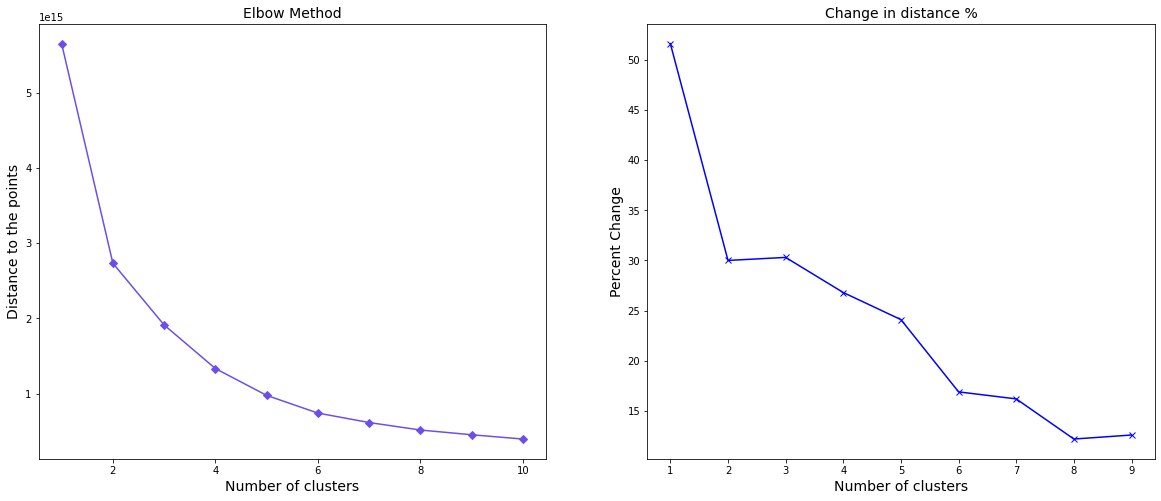

In [172]:
plt.figure(figsize=(20, 8))
# plot wcss to find the 'elbow'
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, color='#6d4ee9', marker='D')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distance to the points')

# plot k with pct_delta
plt.subplot(1, 2, 2)
plt.plot(compare.k, compare.pct_delta, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Percent Change')
plt.title('Change in distance %')
plt.show()

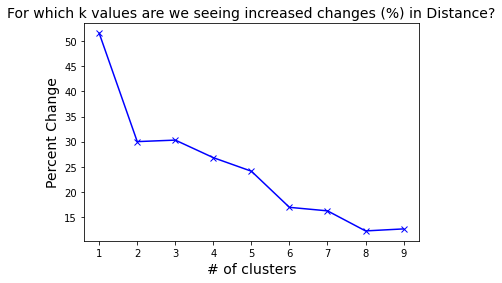

In [167]:
# plot k with pct_delta
plt.plot(compare.k, compare.pct_delta, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Percent Change')
plt.title('For which k values are we seeing increased changes (%) in Distance?')
plt.show()


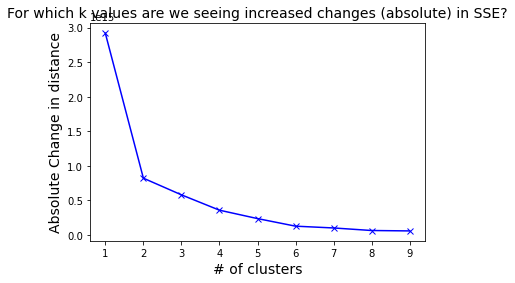

In [166]:
# plot k with delta
plt.plot(compare.k, compare.delta, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Absolute Change in distance')
plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
plt.show()

In [88]:

# compute the difference from one k to the next
delta = [round(wcss[i] - wcss[i+1],0) for i in range(len(wcss)-1)]

In [91]:
delta

[2918871474675462.0,
 820459288892727.0,
 579229225896113.0,
 356982840233648.0,
 235399376442230.0,
 125698776784341.0,
 99702331209176.0,
 62879805574116.0,
 56953266081770.0]

In [89]:
len(delta)

9

In [92]:
# compute the percent difference from one k to the next
pct_delta = [round(((wcss[i] - wcss[i+1])/wcss[i])*100, 1) for i in range(len(wcss)-1)]

In [93]:
# create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
compare = pd.DataFrame(dict(k=k_range[0:-1], 
                         wcss=wcss[0:-1], 
                         delta=delta, 
                         pct_delta=pct_delta))

In [94]:
compare

,k,wcss,delta,pct_delta
0,1,"5,652,697,796,877,278.000","2,918,871,474,675,462.000",51.600
1,2,"2,733,826,322,201,816.500","820,459,288,892,727.000",30.000
2,3,"1,913,367,033,309,089.500","579,229,225,896,113.000",30.300
3,4,"1,334,137,807,412,976.500","356,982,840,233,648.000",26.800
4,5,"977,154,967,179,328.750","235,399,376,442,230.000",24.100
5,6,"741,755,590,737,098.750","125,698,776,784,341.000",16.900
6,7,"616,056,813,952,757.500","99,702,331,209,176.000",16.200
7,8,"516,354,482,743,581.500","62,879,805,574,116.000",12.200
8,9,"453,474,677,169,465.125","56,953,266,081,770.000",12.600


In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 29866 to 13389
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   sqft              27764 non-null  int64   
 1   garage_sqft       27764 non-null  int64   
 2   lot_sqft          27764 non-null  int64   
 3   age               27764 non-null  int64   
 4   structure_price   27764 non-null  int64   
 5   price             27764 non-null  int64   
 6   land_price        27764 non-null  int64   
 7   tax_amount        27764 non-null  float64 
 8   bed_bath_ratio    27764 non-null  float64 
 9   city_id           27764 non-null  int64   
 10  zip               27764 non-null  int64   
 11  latitude          27764 non-null  int64   
 12  longitude         27764 non-null  int64   
 13  bath              27764 non-null  uint8   
 14  beds              27764 non-null  uint8   
 15  fireplace         27764 non-null  uint8   
 16  garage            

In [39]:
def find_the_k(df:pd.DataFrame, k_min:int = 1, k_max:int = 10, list_of_features=None):
    '''
    function accepts a scaled data frame as a parameter,
    range for clusters and list of featured
    visualizes distance to the points for every cluster
    and returns a data frame with calculation results
    '''
    k_range = range(k_min, k_max+1)
    if list_of_features == None:
        list_of_features = df.columns.tolist()
    wcss = [] #Within-Cluster Sum of Square
    k_range = range(1,11)
    clustering = df[list_of_features]
    # run the loop with clusters from 1 to 10 to find the best n_clusters number
    for i in k_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(clustering)
        wcss.append(kmeans.inertia_)
    # compute the difference from one k to the next
    delta = [round(wcss[i] - wcss[i+1],0) for i in range(len(wcss)-1)]
    # compute the percent difference from one k to the next
    pct_delta = [round(((wcss[i] - wcss[i+1])/wcss[i])*100, 1) for i in range(len(wcss)-1)]
    
    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    compare = pd.DataFrame(dict(k=k_range[0:-1], 
                             wcss=wcss[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # visualize points and distances between them
    plt.figure(figsize=(20, 8))
    # plot wcss to find the 'elbow'
    plt.subplot(1, 2, 1)
    plt.plot(k_range, wcss, color='#6d4ee9', marker='D')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distance to the points')
    #plt.xlim(start_point, end_point)

    # plot k with pct_delta
    plt.subplot(1, 2, 2)
    plt.plot(compare.k, compare.pct_delta, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Percent Change')
    plt.title('Change in distance %')
    plt.show()
    
    # return a data frame
    return compare

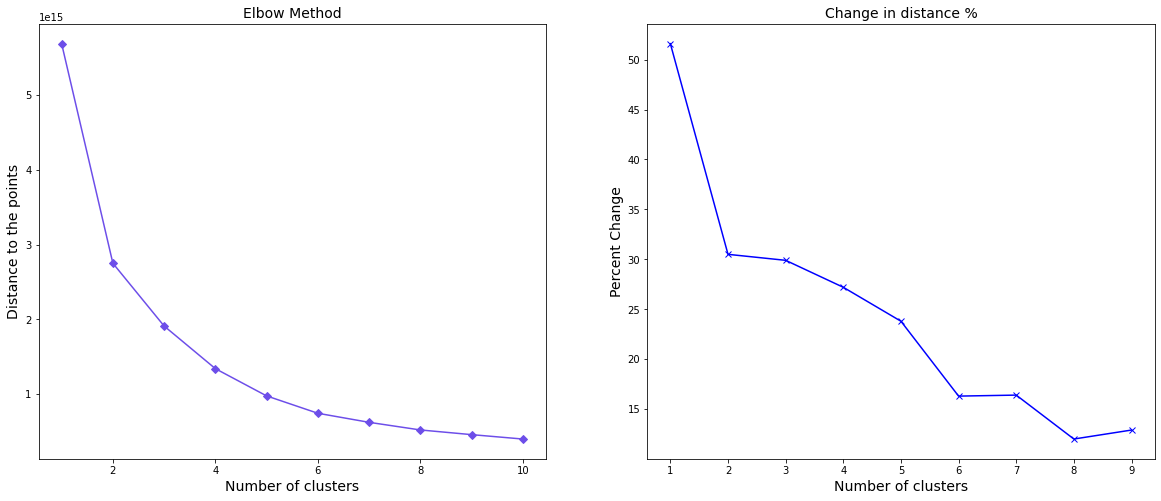

,k,wcss,delta,pct_delta
0,1,"5,688,680,467,820,476.000","2,937,960,992,462,448.000",51.600
1,2,"2,750,719,475,358,028.000","839,922,094,078,508.000",30.500
2,3,"1,910,797,381,279,519.500","570,393,626,297,026.000",29.900
3,4,"1,340,403,754,982,493.750","364,665,754,725,615.000",27.200
4,5,"975,738,000,256,878.625","232,350,213,589,053.000",23.800
5,6,"743,387,786,667,826.000","121,221,132,490,177.000",16.300
6,7,"622,166,654,177,648.625","102,079,403,675,997.000",16.400
7,8,"520,087,250,501,651.438","62,609,538,742,100.000",12.000
8,9,"457,477,711,759,551.750","58,911,503,332,401.000",12.900


In [46]:
find_the_k(train_clust, 1, 15) #6 clusters

In [81]:
location_features = ['latitude', 'longitude', 'county_land_code']
no_zip_location = ['city_id', 'county_land_code']
categorical_features = ['bath', 'beds', 'fireplace', 'garage','hottub_spa', 'pool']# 7 and not clear
clust = ['latitude', 'longitude', 'sqft'] #6
short_categorical = ['bath', 'beds', 'garage','pool']
numerical = ['sqft', 'garage_sqft', 'lot_sqft', 'age'] # 7 and not clear

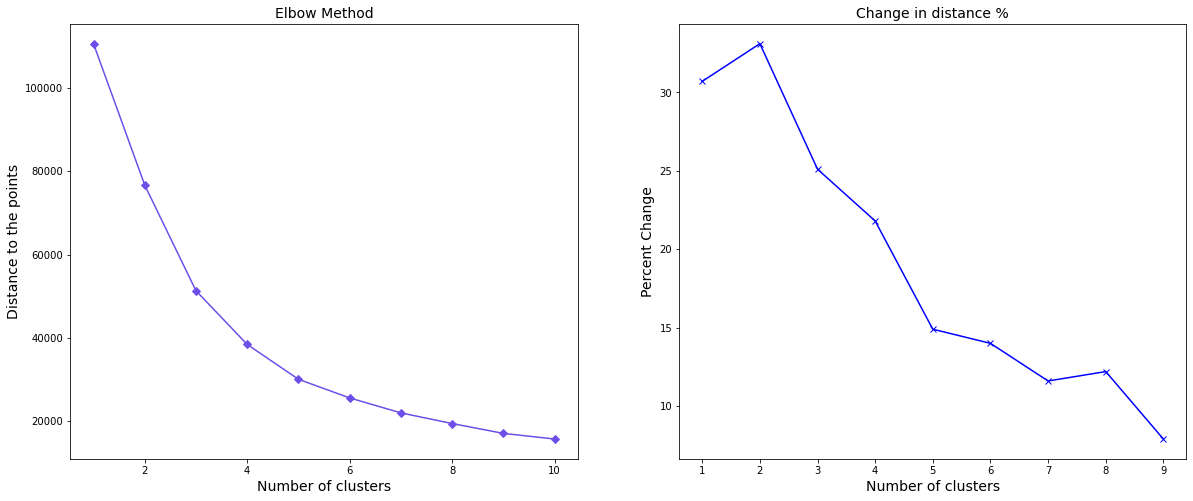

,k,wcss,delta,pct_delta
0,1,"110,608.000","33,960.000",30.700
1,2,"76,648.470","25,347.000",33.100
2,3,"51,301.443","12,890.000",25.100
3,4,"38,411.918","8,360.000",21.800
4,5,"30,051.551","4,477.000",14.900
5,6,"25,574.291","3,590.000",14.000
6,7,"21,984.613","2,556.000",11.600
7,8,"19,428.304","2,367.000",12.200
8,9,"17,061.756","1,351.000",7.900


In [87]:
find_the_k(train_scaled, k_min=1, k_max=15, list_of_features=numerical)

In [231]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/clustering-project/src/wrangle.py'>

In [236]:
df = wr.acquire_zillow()

In [237]:
wr.clean_from_ids(df)

In [241]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   draft-explore.ipynb
	modified:   src/wrangle.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	clustering.ipynb
	clusters.py

no changes added to commit (use "git add" and/or "git commit -a")


In [233]:
df.unitcnt.value_counts(dropna=False)

1.000    33733
NaN      18558
2.000       27
3.000        1
Name: unitcnt, dtype: int64

In [220]:
train.unit.unique()

array([1, 0, 2, 3], dtype=uint8)

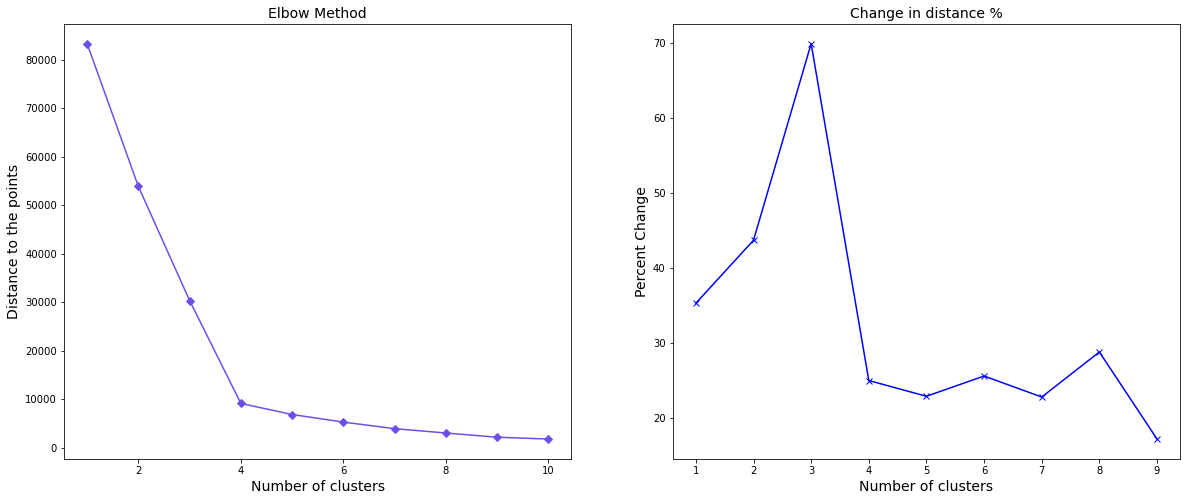

,k,wcss,delta,pct_delta
0,1,"83,292.000","29,429.000",35.300
1,2,"53,862.785","23,522.000",43.700
2,3,"30,340.718","21,209.000",69.900
3,4,"9,131.220","2,284.000",25.000
4,5,"6,847.125","1,566.000",22.900
5,6,"5,281.261","1,350.000",25.600
6,7,"3,930.909",896.000,22.800
7,8,"3,035.165",874.000,28.800
8,9,"2,161.184",371.000,17.200


In [209]:
find_the_k(train_scaled, k_min=1, k_max=15, list_of_features=location_features) # 4

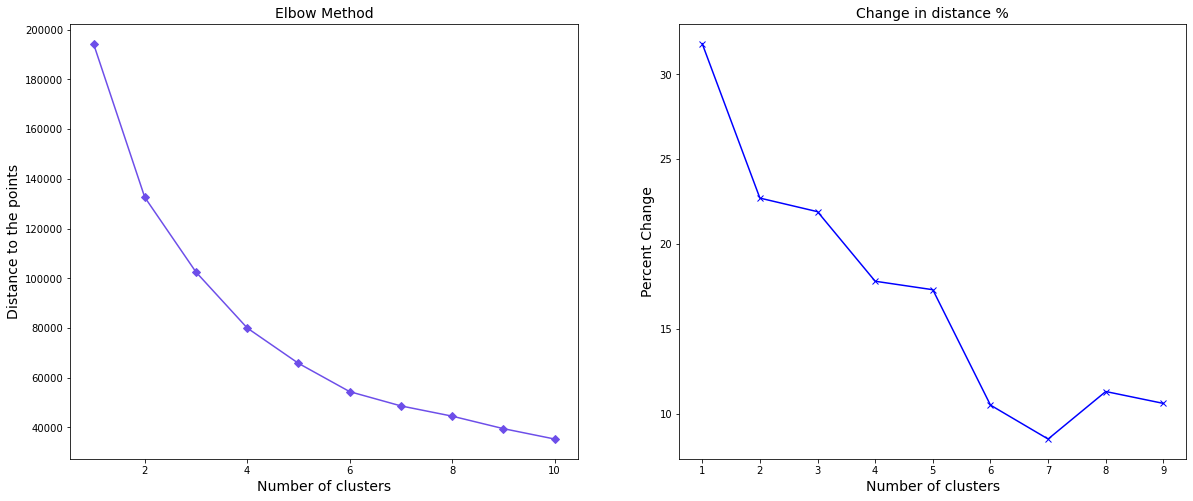

,k,wcss,delta,pct_delta
0,1,"194,348.000","61,776.000",31.800
1,2,"132,572.165","30,091.000",22.700
2,3,"102,481.240","22,492.000",21.900
3,4,"79,989.118","14,218.000",17.800
4,5,"65,771.488","11,391.000",17.300
5,6,"54,380.771","5,733.000",10.500
6,7,"48,648.144","4,122.000",8.500
7,8,"44,525.885","5,027.000",11.300
8,9,"39,499.060","4,172.000",10.600


In [204]:
find_the_k(train_scaled, k_min=1, k_max=15, list_of_features=categorical_features)

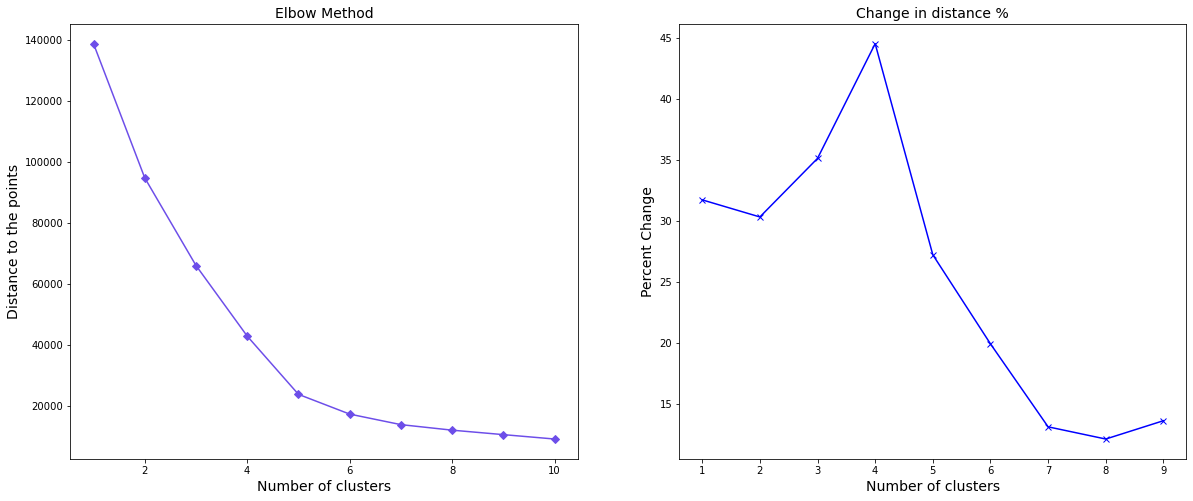

,k,wcss,delta,pct_delta
0,1,"138,820.000","44,012.000",31.700
1,2,"94,807.668","28,741.000",30.300
2,3,"66,066.457","23,167.000",35.100
3,4,"42,899.646","19,099.000",44.500
4,5,"23,800.918","6,477.000",27.200
5,6,"17,324.034","3,453.000",19.900
6,7,"13,871.054","1,816.000",13.100
7,8,"12,054.648","1,463.000",12.100
8,9,"10,591.308","1,442.000",13.600


In [217]:
find_the_k(train_scaled, 1, 15, lat_long+location_features) #5

In [215]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/clustering-project/src/wrangle.py'>

In [218]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27764 entries, 29866 to 13389
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sqft              27764 non-null  int64  
 1   garage_sqft       27764 non-null  int64  
 2   lot_sqft          27764 non-null  int64  
 3   age               27764 non-null  int64  
 4   structure_price   27764 non-null  int64  
 5   price             27764 non-null  int64  
 6   land_price        27764 non-null  int64  
 7   tax_amount        27764 non-null  float64
 8   bed_bath_ratio    27764 non-null  float64
 9   city_id           27764 non-null  int64  
 10  zip               27764 non-null  int64  
 11  latitude          27764 non-null  int64  
 12  longitude         27764 non-null  int64  
 13  bath              27764 non-null  uint8  
 14  beds              27764 non-null  uint8  
 15  fireplace         27764 non-null  uint8  
 16  garage            27764 non-null  ui

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(clustering)

In [74]:
cols = train.iloc[:, :8].columns.tolist() + ['latitude', 'longitude']

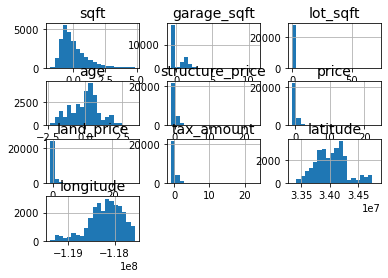

In [76]:
train[cols].hist(bins = 20);

In [205]:
!code clusters.py

In [ ]:
find_the_k(train_scaled.

In [97]:
reload(wr)

<module 'src.wrangle' from '/Users/nadina/codeup-data-science/clustering-project/src/wrangle.py'>

In [135]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wr.full_split_zillow(wr.get_zillow())

In [136]:
X_train_sc, X_validate_sc, X_test_sc = wr.standard_scale_zillow(X_train, X_validate, X_test, clustering=True)

In [100]:
X_train.head()

,sqft,garage_sqft,lot_sqft,age,structure_price,price,land_price,tax_amount,bath,beds,...,zip,latitude,longitude,fireplace,garage,hottub_spa,pool,county_land_code,county_number,county_name
15546,1.490,-0.684,-0.006,-0.794,0.927,0.206,-0.148,0.122,0.899,1.941,...,96330,34230997,-118232317,0,0,0,0,100,0,LA
50614,-0.851,-0.684,-0.053,1.729,-0.261,0.217,0.409,0.121,-1.330,-1.451,...,96433,34199336,-118292655,0,0,0,0,100,0,LA
46289,-0.243,-0.684,-0.048,0.622,-0.203,-0.224,-0.206,-0.243,-0.216,0.810,...,96240,33806056,-118201181,0,0,0,0,100,0,LA
39699,-0.687,-0.684,-0.060,0.534,-0.794,-0.735,-0.618,-0.676,-0.216,-0.321,...,96095,33989003,-118403646,0,0,0,0,100,0,LA
29962,0.263,-0.684,-0.050,-0.529,0.178,0.211,0.201,0.324,0.899,0.810,...,96378,34389597,-118554462,0,0,0,1,101,0,LA


In [108]:
reload(cl)

<module 'clusters' from '/Users/nadina/codeup-data-science/clustering-project/clusters.py'>

In [104]:
import clusters as cl

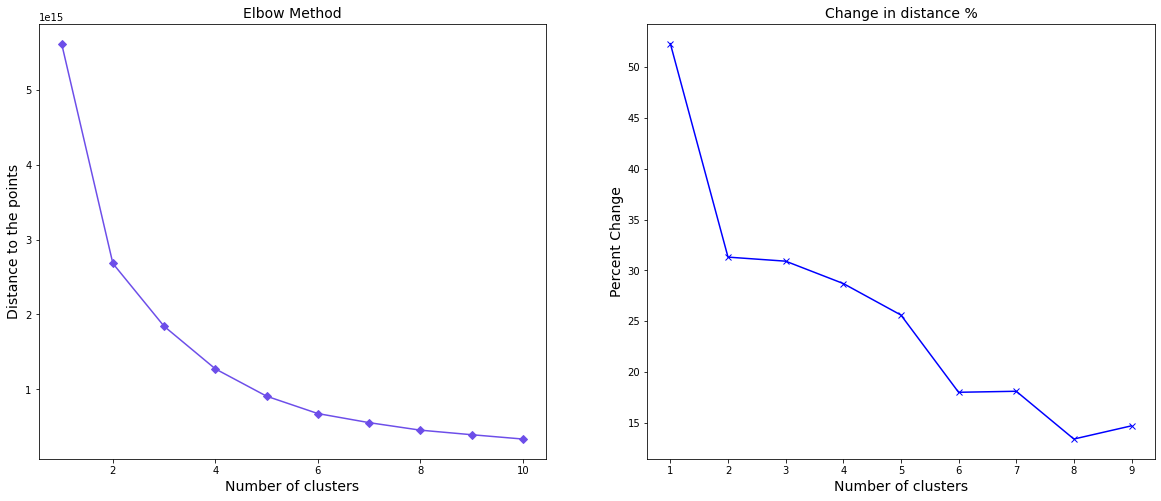

,k,wcss,delta,pct_delta
0,1,"5,619,665,279,991,818.000","2,937,905,295,316,473.000",52.300
1,2,"2,681,759,984,675,345.000","839,739,276,988,968.000",31.300
2,3,"1,842,020,707,686,376.750","569,519,599,127,945.000",30.900
3,4,"1,272,501,108,558,432.000","365,108,539,995,547.000",28.700
4,5,"907,392,568,562,884.625","232,150,057,221,312.000",25.600
5,6,"675,242,511,341,572.500","121,375,344,079,137.000",18.000
6,7,"553,867,167,262,435.125","100,449,500,488,630.000",18.100
7,8,"453,417,666,773,805.062","60,848,144,657,736.000",13.400
8,9,"392,569,522,116,068.688","57,814,719,690,608.000",14.700


In [109]:
cl.find_the_k(X_train, 1, 10, ['latitude', 'longitude'])

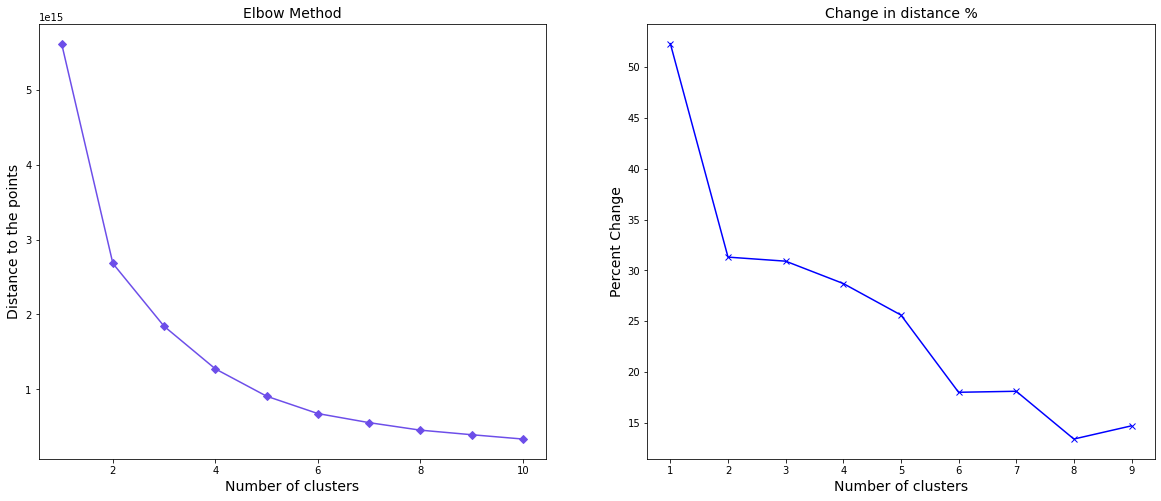

,k,wcss,delta,pct_delta
0,1,"5,619,665,279,991,818.000","2,937,905,295,316,473.000",52.300
1,2,"2,681,759,984,675,345.000","839,739,276,988,968.000",31.300
2,3,"1,842,020,707,686,377.000","569,519,599,127,945.000",30.900
3,4,"1,272,501,108,558,431.750","365,108,539,995,547.000",28.700
4,5,"907,392,568,562,884.625","232,150,057,221,312.000",25.600
5,6,"675,242,511,341,572.500","121,375,344,079,137.000",18.000
6,7,"553,867,167,262,435.125","100,449,500,488,630.000",18.100
7,8,"453,417,666,773,805.062","60,848,144,657,736.000",13.400
8,9,"392,569,522,116,068.688","57,814,719,690,608.000",14.700


In [101]:
find_the_k(X_train, 1, 10, ['latitude', 'longitude'])

In [110]:
reload(cl)

<module 'clusters' from '/Users/nadina/codeup-data-science/clustering-project/clusters.py'>

In [116]:
### clustering on latitude and longitude 
seed = 42
location = ['latitude', 'longitude']
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=seed)
loc_train = kmeans.fit_predict(X_train[location])
loc_validate = kmeans.predict(X_validate[location])
loc_test = kmeans.predict(X_test[location])

In [119]:
len(loc_train) == len(X_train), len(loc_validate) == len(X_validate), len(loc_test) == len(X_test)

(True, True, True)

In [120]:

numerical = ['sqft', 'garage_sqft', 'lot_sqft', 'age']
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
num_train = kmeans.fit_predict(X_train[numerical])
num_validate = kmeans.predict(X_validate[numerical])
num_test = kmeans.predict(X_test[numerical])

In [122]:
num_test

array([1, 4, 4, ..., 1, 0, 4], dtype=int32)

In [127]:
X_train['location_clusters'] = loc_train.astype('uint8')
X_validate['location_clusters'] = loc_validate.astype('uint8')
X_test['location_clusters'] = loc_test.astype('uint8')

In [126]:
X_train['numerical_clusters'] = num_train.astype('uint8')
X_validate['numerical_clusters'] = num_validate.astype('uint8')
X_test['numerical_clusters'] = num_test.astype('uint8')

In [133]:
len(num_train) == len(X_train) == len(train), len(num_validate) == len(X_validate), len(num_test) == len(X_test)

(True, True, True)

In [128]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27652 entries, 15546 to 19930
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sqft                27652 non-null  float64
 1   garage_sqft         27652 non-null  float64
 2   lot_sqft            27652 non-null  float64
 3   age                 27652 non-null  float64
 4   structure_price     27652 non-null  float64
 5   price               27652 non-null  float64
 6   land_price          27652 non-null  float64
 7   tax_amount          27652 non-null  float64
 8   bath                27652 non-null  float64
 9   beds                27652 non-null  float64
 10  bed_bath_ratio      27652 non-null  float64
 11  city_id             27652 non-null  int64  
 12  zip                 27652 non-null  int64  
 13  latitude            27652 non-null  int64  
 14  longitude           27652 non-null  int64  
 15  fireplace           27652 non-null  uint8  
 16  

In [138]:
def run_clustering_location():
    '''
    the function create clusters based on latitude and longitude values
    return 3 arrays with cluster numbers that can be added to the train/validate/test data frames
    '''
    kmeans = KMeans(n_clusters=6, init='k-means++', random_state=seed)
    loc_train = kmeans.fit_predict(X_train[location])
    loc_validate = kmeans.predict(X_validate[location])
    loc_test = kmeans.predict(X_test[location])
    return loc_train, loc_validate, loc_test
def run_clusterin_numerical():
    '''
    the function create clusters based on numerical columns
    return 3 arrays with cluster numbers that can be added to the train/validate/test data frames
    '''
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
    num_train = kmeans.fit_predict(X_train[numerical])
    num_validate = kmeans.predict(X_validate[numerical])
    num_test = kmeans.predict(X_test[numerical])
    return num_train, num_validate, num_test


def add_location_clusters(train, validate, test): 
    '''
    the function accepts train, validate, test as parameters
    returns those sets with columns with clusters attached
    '''
    train['location_clusters'] = loc_train.astype('uint8')
    validate['location_clusters'] = loc_validate.astype('uint8')
    test['location_clusters'] = loc_test.astype('uint8')
    train['numerical_clusters'] = num_train.astype('uint8')
    validate['numerical_clusters'] = num_validate.astype('uint8')
    test['numerical_clusters'] = num_test.astype('uint8')
    
    return train, validate, test

In [139]:
train, X_validate, X_test = add_location_clusters(train, X_validate, X_test)

In [153]:
def add_clusters_to_train(df):
    df['location_clusters'] = loc_train.astype('uint8')
    df['numerical_clusters'] = num_train.astype('uint8')
    return df

In [154]:
train = add_clusters_to_train(train)

([], [])

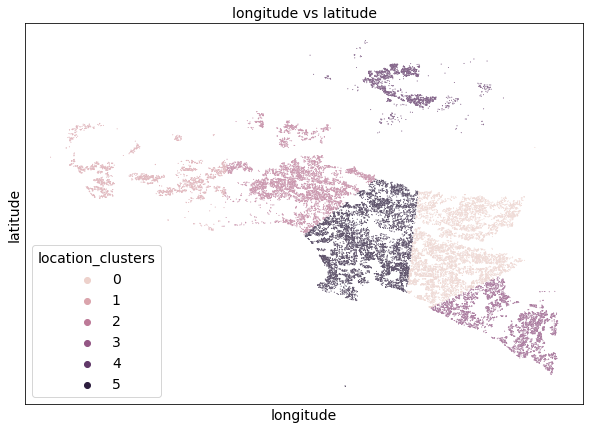

In [140]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=train, x='longitude', y='latitude', s=1, hue='location_clusters')
plt.title('longitude vs latitude')
plt.yticks([])
plt.xticks([])

In [ ]:
palettes = ['flare', 'Blues_r', 'PuRd_r', 'Accent']
colors_sns = sns.color_palette("flare")
colors_sns2 = sns.color_palette("Blues_r")

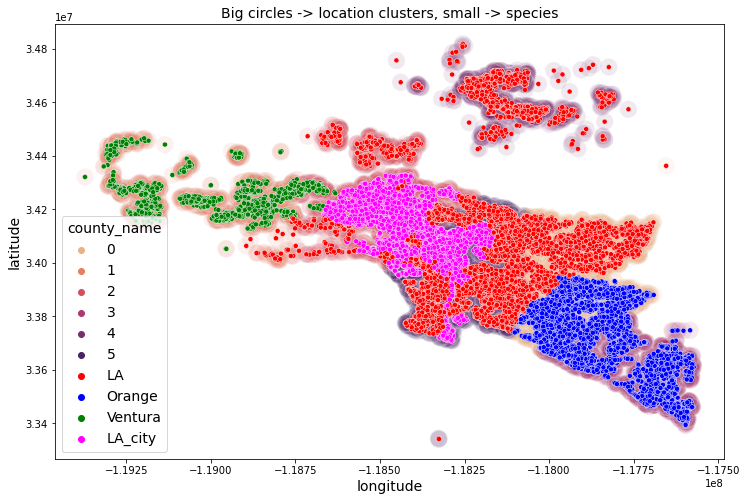

In [145]:
colors = ['red', 'blue', 'green', 'magenta']
palette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='longitude', y='latitude', hue='location_clusters', palette='flare', s=300, alpha=0.1)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette=palette, s=25)
plt.title('Big circles -> location clusters, small -> species')
plt.show()

In [141]:
train.columns

Index(['sqft', 'garage_sqft', 'lot_sqft', 'age', 'structure_price', 'price',
       'land_price', 'tax_amount', 'bath', 'beds', 'bed_bath_ratio', 'city_id',
       'zip', 'latitude', 'longitude', 'fireplace', 'garage', 'hottub_spa',
       'pool', 'county_land_code', 'county_number', 'county_name', 'logerror',
       'location_clusters', 'numerical_clusters'],
      dtype='object')

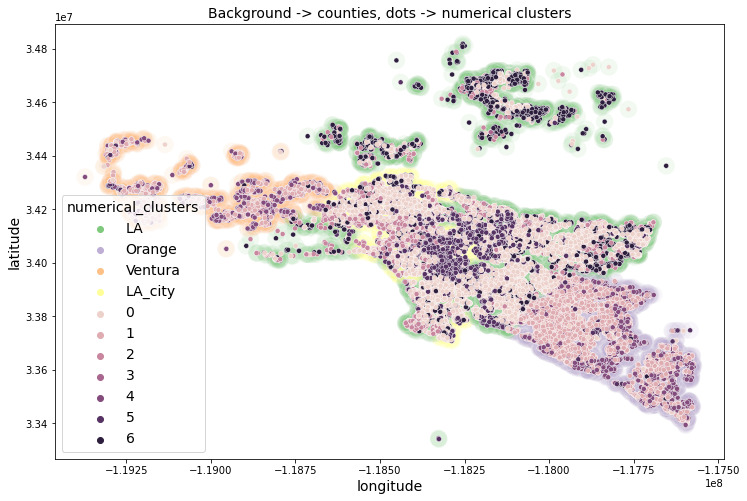

In [150]:
colors = ['red', 'blue', 'green', 'magenta']
palette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='numerical_clusters', palette=palette, s=25)
plt.title('Background -> counties, dots -> numerical clusters')
plt.show()

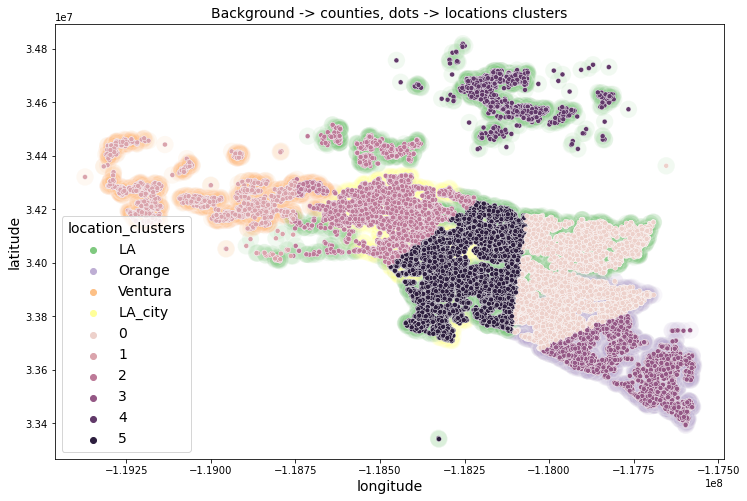

In [152]:
colors = ['red', 'blue', 'green', 'magenta']
palette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='location_clusters', palette=palette, s=25)
plt.title('Background -> counties, dots -> locations clusters')
plt.show()

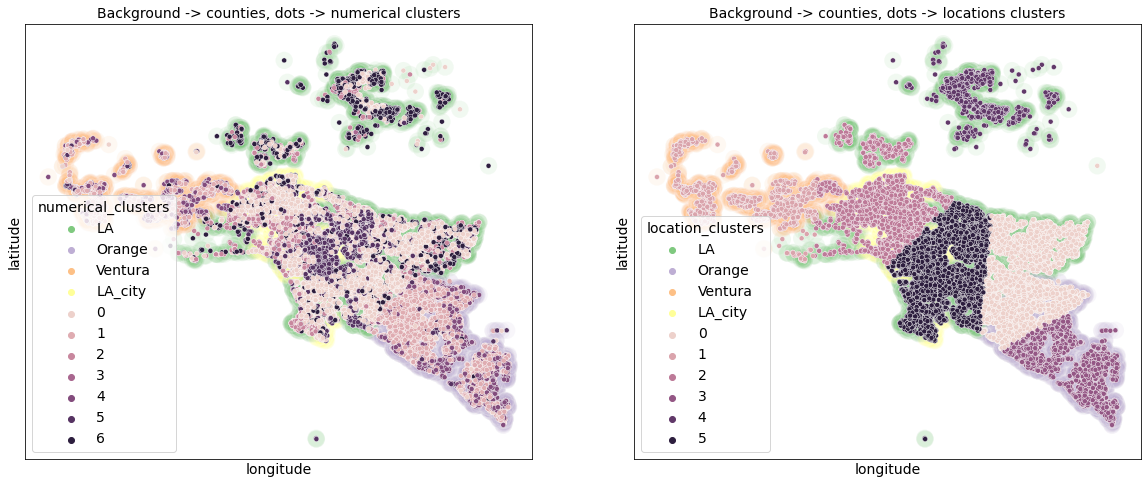

In [156]:
colors = ['red', 'blue', 'green', 'magenta']
palette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(20, 8))

plt.subplot(121)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='numerical_clusters', palette=palette, s=25)
plt.title('Background -> counties, dots -> numerical clusters')
plt.yticks([])
plt.xticks([])

plt.subplot(122)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1)
sns.scatterplot(data=train, x='longitude', y='latitude', hue='location_clusters', palette=palette, s=25)
plt.title('Background -> counties, dots -> locations clusters')
plt.yticks([])
plt.xticks([])
plt.show()

In [175]:
def viz_clustering_results():
    colors = ['red', 'blue', 'green', 'magenta']
    palette = sns.set_palette(sns.color_palette(colors))
    plt.figure(figsize=(20, 8))

    plt.suptitle('Clustering results')
    plt.subplot(121)
    sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1, legend=None)
    sns.scatterplot(data=train, x='longitude', y='latitude', hue='numerical_clusters', palette=palette, s=25, legend=None)
    plt.title('Background -> counties, dots -> numerical clusters')
    plt.yticks([])
    plt.xticks([])

    plt.subplot(122)
    sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', palette='Accent', s=300, alpha=0.1, legend=None)
    sns.scatterplot(data=train, x='longitude', y='latitude', hue='location_clusters', palette=palette, s=25, legend=None)
    plt.title('Background -> counties, dots -> locations clusters')
    plt.yticks([])
    plt.xticks([])
    plt.show()

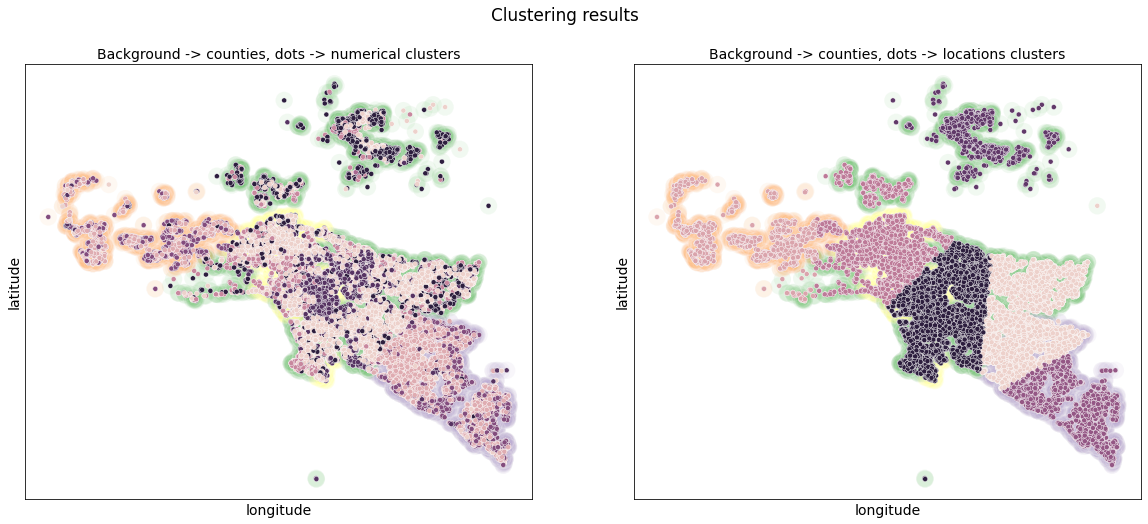

In [176]:
viz_clustering_results()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

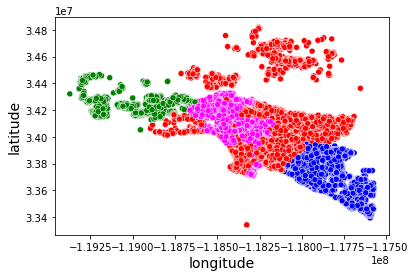

In [162]:
sns.scatterplot(data=train, x='longitude', y='latitude', hue='county_name', legend=None)

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=seed)
loc_train = kmeans.fit_predict(X_train[location])
loc_validate = kmeans.predict(X_validate[location])
loc_test = kmeans.predict(X_test[location])
return loc_train, loc_validate, loc_test

In [ ]:
train, validate, test = wr.split_zillow(df)